<a href="https://colab.research.google.com/github/sahil301290/CRBP-3D-to-2.5D/blob/main/02_CRBP_FR_EfficientNetb0_over_CRBP_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition over CRBP-Yolov8
### Using EfficientNetb0 over 105 subjects | Train,val,test: (60,20,20)

In [1]:
!gdown 1EgVcuzX2IghjBYFnPaGMEwFYNpo4QJI4 -O CRBP-Yolov8.zip
!gdown 1X0Nz1x2r31scd3cTTRwJ9LnCZYRuSdn6 -O CRBP-Raw.zip
!unzip -q "/content/CRBP-Yolov8.zip"
!rm -rf "/content/CRBP-Yolov8.zip"
!unzip -q "/content/CRBP-Raw.zip"
!rm -rf "/content/CRBP-Raw.zip"
!apt-get install -y p7zip-full
!7z x "/content/drive/MyDrive/Datasets/3D Face/Bosphorus_Unzipped.zip" -o"/content/Bosphorus" -mmt

Downloading...
From (original): https://drive.google.com/uc?id=1EgVcuzX2IghjBYFnPaGMEwFYNpo4QJI4
From (redirected): https://drive.google.com/uc?id=1EgVcuzX2IghjBYFnPaGMEwFYNpo4QJI4&confirm=t&uuid=43f675a1-3072-4407-93ee-b6430a7fc3c2
To: /content/CRBP-Yolov8.zip
100% 1.04G/1.04G [00:14<00:00, 69.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1X0Nz1x2r31scd3cTTRwJ9LnCZYRuSdn6
From (redirected): https://drive.google.com/uc?id=1X0Nz1x2r31scd3cTTRwJ9LnCZYRuSdn6&confirm=t&uuid=d08e1786-d2c6-47e2-bc98-09899ff5e1d0
To: /content/CRBP-Raw.zip
100% 2.39G/2.39G [00:32<00:00, 72.9MB/s]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (4

In [2]:
!pip install -q timm

import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
import torch.optim as optim
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.1 MB/s eta 0:00:00


In [3]:
import os
os.makedirs("/content/CRBP/ML/Encoder", exist_ok=True)
os.makedirs("/content/CRBP/ML/Codes", exist_ok=True)
os.makedirs("/content/CRBP/ML", exist_ok=True)

In [42]:
os.makedirs("/content/CRBP/ML/Visualizations", exist_ok=True)

In [4]:
%%writefile CRBP/ML/Encoder/encodeResize.py
import torch.nn as nn

class CNNResizer(nn.Module):
    """
    A learnable resizer to convert input images of arbitrary size
    into 224x224 using convolution and adaptive pooling.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((224, 224))
        )

    def forward(self, x):
        return self.encoder(x)

if __name__ == "__main__":
    pass

Writing CRBP/ML/Encoder/encodeResize.py


In [5]:
%%writefile CRBP/ML/Codes/EfficientNetb0.py
import torch.nn as nn
from timm import create_model
from CRBP.ML.Encoder.encodeResize import CNNResizer

class FaceRecognitionModel(nn.Module):
    """
    Full model combining the CNN resizer and EfficientNet-B0.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.resizer = CNNResizer(in_channels=3, out_channels=3)
        self.backbone = create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = self.resizer(x)
        return self.backbone(x)

if __name__ == "__main__":
    pass

Writing CRBP/ML/Codes/EfficientNetb0.py


In [34]:
# Root init
!touch /content/CRBP/__init__.py

# ML module init
!touch /content/CRBP/ML/__init__.py

# Codes and Encoder modules
!touch /content/CRBP/ML/Codes/__init__.py
!touch /content/CRBP/ML/Encoder/__init__.py

# Optional: Results folder (not required unless you're importing from it)
!touch /content/CRBP/ML/Results/__init__.py

In [35]:
!pip install -q tqdm

In [46]:
%%writefile CRBP/ML/main_train.py
import os
import torch
import torch.nn as nn
from PIL import ImageOps
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, matthews_corrcoef, roc_auc_score)
import pandas as pd
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('/content')
from CRBP.ML.Codes.EfficientNetb0 import FaceRecognitionModel

# === Config ===
DATA_DIR = "/content/CRBP-Yolov8"
RESULTS_DIR = "/content/CRBP/ML/Results"
os.makedirs(RESULTS_DIR, exist_ok=True)
SEED = 42
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # === Dataset and Transform ===
# Pad all images to fixed 600x600
def pad_to_fixed_size(image, size=(600, 600)):
    return ImageOps.pad(image, size, color=(0, 0, 0))  # no scaling, black padding

transform = transforms.Compose([
    transforms.Lambda(lambda img: pad_to_fixed_size(img, size=(600, 600))),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
num_classes = len(full_dataset.classes)

# === Sanity check: inspect shape of first 5 images
print("\n[Sanity Check] Inspecting shapes of first 5 images in dataset:")
for i in range(5):
    img, label = full_dataset[i]
    print(f"Sample {i}: shape={img.shape}, dtype={img.dtype}, label={label}")

# === Split Dataset: 60/20/20 ===
total_len = len(full_dataset)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

train_set, val_set, test_set = random_split(
    full_dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# === Model, Loss, Optimizer ===
model = FaceRecognitionModel(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Use AdamW optimizer (better regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Step-based learning rate scheduler: halve LR every 5 epochs
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_f1': [],
    'learning_rate': []
}


# === Training ===
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    print(f"\n[Epoch {epoch+1}] Starting training...")
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Training Loss: {avg_train_loss:.4f}")

    # === Validation ===
    model.eval()
    val_loss = 0
    val_true, val_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_true, val_pred)
    val_f1 = f1_score(val_true, val_pred, average='weighted', zero_division=0)

    print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # Save to history
    history['epoch'].append(epoch+1)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['learning_rate'].append(scheduler.get_last_lr()[0])

    scheduler.step()

# === Evaluation ===
print("\n[Evaluation] Running on test set...")
model.eval()
y_true, y_pred, y_proba = [], [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_proba.extend(probs.cpu().numpy())

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(os.path.join(RESULTS_DIR, "training_history.csv"), index=False)
print("\nTraining history saved to training_history.csv")


# === Metrics Calculation ===
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba_np = np.array(y_proba)

metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
    "Recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
    "F1 Score": f1_score(y_true, y_pred, average='weighted', zero_division=0),
    "MCC": matthews_corrcoef(y_true, y_pred),
    "AUC ROC": roc_auc_score(y_true, y_proba_np, multi_class='ovo', average='weighted')
}

# === Save Results ===
results_df = pd.DataFrame([metrics])
results_df.to_csv(os.path.join(RESULTS_DIR, "metrics_results.csv"), index=False)

print("\nEvaluation Metrics:")
print(results_df.to_string(index=False))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc

# === Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# === Compute ROC + PR curves (One-vs-Rest strategy)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
pr_auc = dict()

y_true_bin = pd.get_dummies(y_true).values  # one-hot encoding

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba_np[:, i])
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_proba_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    pr_auc[i] = auc(recall[i], precision[i])

# === Macro-average ROC & PR
fpr["macro"] = np.linspace(0, 1, 100)
tpr_interp = np.zeros_like(fpr["macro"])
prec_interp = np.zeros_like(fpr["macro"])

for i in range(num_classes):
    tpr_interp += np.interp(fpr["macro"], fpr[i], tpr[i])
    prec_interp += np.interp(fpr["macro"], recall[i][::-1], precision[i][::-1])  # PR: x=recall

tpr["macro"] = tpr_interp / num_classes
precision["macro"] = prec_interp / num_classes
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
pr_auc["macro"] = auc(fpr["macro"], precision["macro"])

# === Plot triplet: (a) CM, (b) PR, (c) ROC
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=600)

# (a) Confusion Matrix
axs[0].set_title("(a) Confusion Matrix", fontsize=14, fontweight='bold')
disp.plot(ax=axs[0], cmap="Blues", colorbar=False)
axs[0].set_xlabel("Predicted", fontsize=12)
axs[0].set_ylabel("True", fontsize=12)

# (b) Precision–Recall Curve
axs[1].plot(fpr["macro"], precision["macro"], label=f"Macro AUC = {pr_auc['macro']:.2f}", color="darkorange", lw=2)
axs[1].set_title("(b) Precision–Recall Curve", fontsize=14, fontweight='bold')
axs[1].set_xlabel("Recall", fontsize=12)
axs[1].set_ylabel("Precision", fontsize=12)
axs[1].legend(loc="lower left", fontsize=10)
axs[1].grid(True)

# (c) ROC Curve
axs[2].plot(fpr["macro"], tpr["macro"], label=f"Macro AUC = {roc_auc['macro']:.2f}", color="darkgreen", lw=2)
axs[2].plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1)
axs[2].set_title("(c) ROC Curve", fontsize=14, fontweight='bold')
axs[2].set_xlabel("False Positive Rate", fontsize=12)
axs[2].set_ylabel("True Positive Rate", fontsize=12)
axs[2].legend(loc="lower right", fontsize=10)
axs[2].grid(True)

plt.tight_layout()

# === Save
fig_path_png = "/content/CRBP/ML/Visualizations/final_metrics_triplet.png"
fig_path_pdf = "/content/CRBP/ML/Visualizations/final_metrics_triplet.pdf"
plt.savefig(fig_path_png, dpi=600, bbox_inches="tight")
plt.savefig(fig_path_pdf, dpi=600, bbox_inches="tight")
print(f"\n📊 Saved metrics visualization:\n→ {fig_path_png}\n→ {fig_path_pdf}")

Overwriting CRBP/ML/main_train.py


In [40]:
!pwd

/content/CRBP


In [45]:
%cd ..

/content


In [47]:
%cd /content/CRBP

/content/CRBP


In [48]:
!python /content/CRBP/ML/main_train.py


[Sanity Check] Inspecting shapes of first 5 images in dataset:
Sample 0: shape=torch.Size([3, 600, 600]), dtype=torch.float32, label=0
Sample 1: shape=torch.Size([3, 600, 600]), dtype=torch.float32, label=0
Sample 2: shape=torch.Size([3, 600, 600]), dtype=torch.float32, label=0
Sample 3: shape=torch.Size([3, 600, 600]), dtype=torch.float32, label=0
Sample 4: shape=torch.Size([3, 600, 600]), dtype=torch.float32, label=0

[Epoch 1] Starting training...
Epoch 1/10: 100% 286/286 [03:53<00:00,  1.22it/s]
[Epoch 1] Training Loss: 3.6037
[Epoch 1] Val Loss: 2.3989 | Val Acc: 0.4127 | Val F1: 0.3806

[Epoch 2] Starting training...
Epoch 2/10: 100% 286/286 [03:49<00:00,  1.24it/s]
[Epoch 2] Training Loss: 1.7725
[Epoch 2] Val Loss: 1.2642 | Val Acc: 0.6988 | Val F1: 0.6938

[Epoch 3] Starting training...
Epoch 3/10: 100% 286/286 [03:52<00:00,  1.23it/s]
[Epoch 3] Training Loss: 0.9437
[Epoch 3] Val Loss: 1.0144 | Val Acc: 0.7408 | Val F1: 0.7414

[Epoch 4] Starting training...
Epoch 4/10: 100%

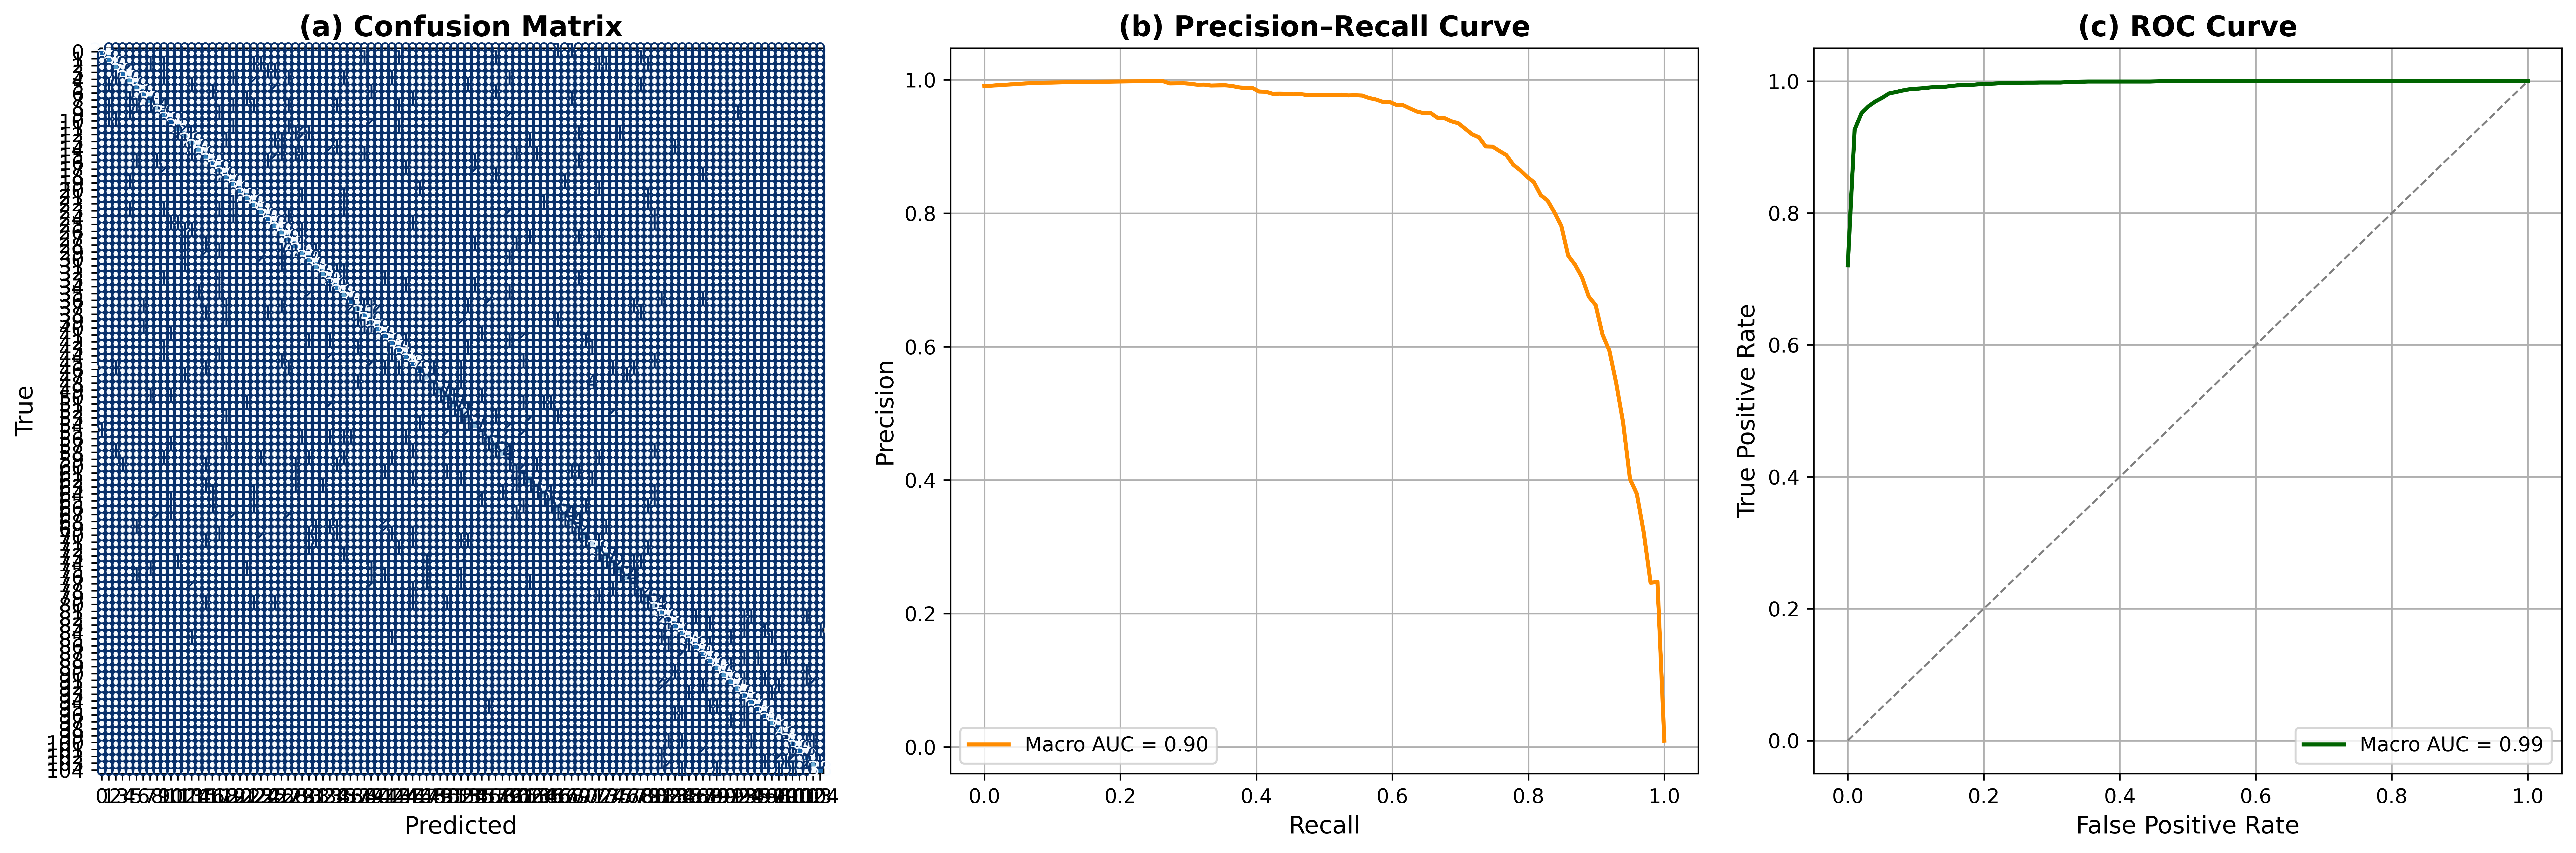

In [49]:
from IPython.display import Image, display

image_path = "/content/CRBP/ML/Visualizations/final_metrics_triplet.png"
display(Image(filename=image_path))

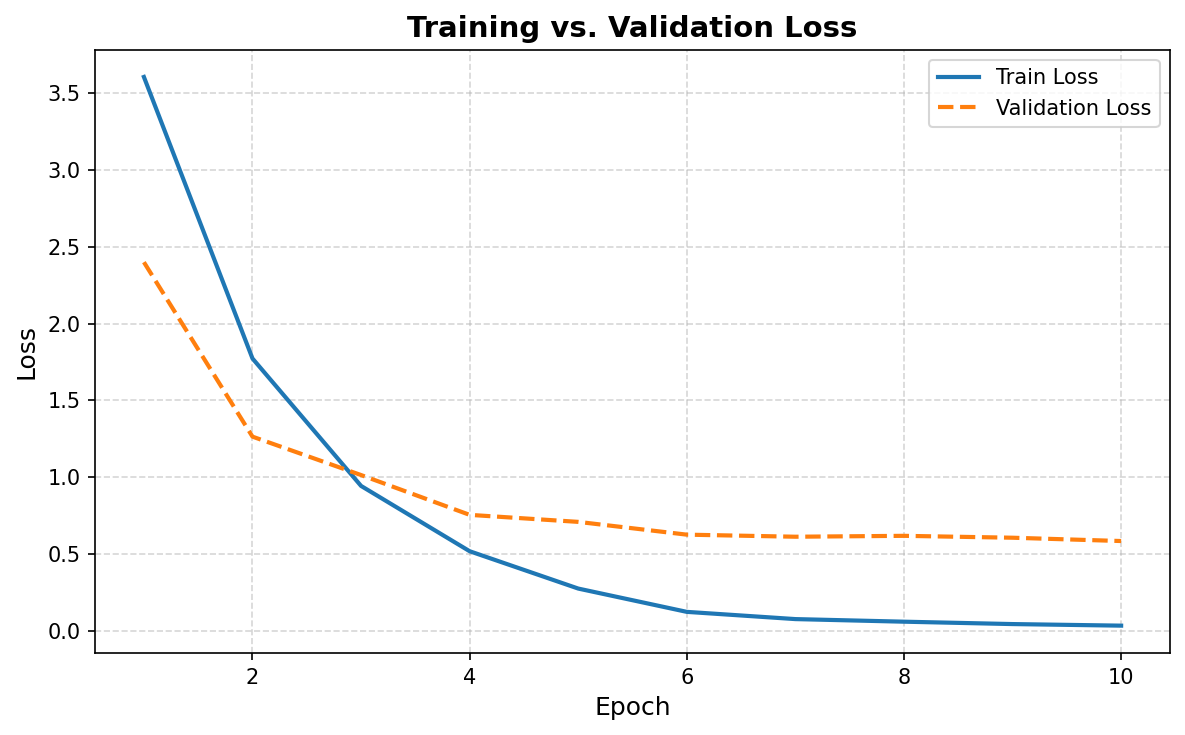

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# === Load training history
history_path = "/content/CRBP/ML/Results/training_history.csv"
history = pd.read_csv(history_path)

# === Plot
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(history['epoch'], history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')

# === Style (Nature Medicine-like)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs. Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# === Save plot
os.makedirs("/content/CRBP/ML/Visualizations", exist_ok=True)
png_path = "/content/CRBP/ML/Visualizations/loss_curve.png"
pdf_path = "/content/CRBP/ML/Visualizations/loss_curve.pdf"
plt.savefig(png_path, dpi=600)
plt.savefig(pdf_path, dpi=600)

# === Show
plt.show()